# GRAPH WITH BTAGGED 2J1P GCNConv

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.loader import DataLoader
import pandas as pd
import random
import os
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, GCNConv, global_max_pool
from tqdm import tqdm
import torch.optim as optim
import json
import pprint

In [2]:
from helper_function_module import init_setup
seed = 4573
BATCH_SIZE = 70
device = init_setup(batch_size = BATCH_SIZE, 
           use_cuda = True, 
           random_seed = seed)

Using device: cpu
System CUDA Status:
- PyTorch version: 2.5.1+cu124
- CUDA Version: 12.4
- CUDA available: False

PyTorch Geometric Status:
- PyG version: 2.6.1
- torch_scatter: Installed
- torch_sparse: Installed
- torch_cluster: Installed
- torch_spline_conv: Installed


# Importing the Main tabular data

In [3]:
with open('json_data/signal_btag_label.json', 'r') as file:
    signal = json.load(file)

with open('json_data/background_btag_label.json', 'r') as file:
    background = json.load(file)

In [4]:
pp = pprint.PrettyPrinter(indent=1)

print(f"Signal Event: {len(signal)}")
print("Example:")
pp.pprint(signal[np.random.randint(0, len(signal))])
print(100*'~')

print(f"Background Event: {len(background)}")
print("Example:")
pp.pprint(background[np.random.randint(0, len(background))])

Signal Event: 119966
Example:
{'edge_index': [[0], [1]],
 'edges': [2.9188417675654024],
 'event_label': 1,
 'eventno': 26995,
 'inv_mass': 75.77595530876465,
 'jet_btag_label': [0.0, 0.0],
 'jetmultiplicity': 1,
 'node_labels': [0, 1],
 'nodes': [[-1.42632, 1.67101, 24.077, 53.0119],
           [-0.540455, -1.83101, 50.6452, 58.2235]]}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Background Event: 126444
Example:
{'edge_index': [[0], [1]],
 'edges': [3.1435932653854888],
 'event_label': 0,
 'eventno': 214520,
 'inv_mass': 55.974294720491116,
 'jet_btag_label': [0.0, 1.0],
 'jetmultiplicity': 1,
 'node_labels': [0, 1],
 'nodes': [[1.25263, 0.978169, 17.1171, 32.3965],
           [-0.425194, -1.68023, 25.0339, 27.3312]]}


# Converting Each Event into a PyG Graph Object

In [5]:
def convert_to_pyg_graph(graph):
    """
    Convert the graph dictionary into a PyTorch Geometric Data object
    and add graph-level features like jet_multiplicity, inv_mass, and the event label.

    Parameters:
    -----------
    graph : dict
        Dictionary containing 'nodes', 'edges', and 'edge_index', 'jet_multiplicity', 'inv_mass' for a single event.
    label : int
        The label of the event (1 for signal, 0 for background).

    Returns:
    --------
    data : Data
        PyTorch Geometric Data object containing the graph and additional features.
    """
    # Extract node features, edge features, and edge index from the graph dictionary
    event_num = torch.tensor(graph['eventno'], dtype=torch.long)
    node_features = torch.tensor(graph['nodes'], dtype=torch.float)  # Shape: (3, num_features)
    edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)  # Shape: (2, num_edges)
    edge_features = torch.tensor(graph['edges'], dtype=torch.float).view(-1,1)  # Shape: (num_edges, 1)
    node_labels = torch.tensor(graph['node_labels'], dtype=torch.float).view(-1,1)
    jet_btag_labels = torch.tensor(graph['jet_btag_label'], dtype=torch.float).view(-1,1)
    
    # Convert graph-level features (jet_multiplicity, inv_mass) and label to tensor
    graph_level_features = torch.tensor([graph['jetmultiplicity'],
                                         graph['inv_mass'],
                                         np.array(graph['edges']).std(),
                                        graph['node_labels'].count(0),
                                        graph['jet_btag_label'].count(1)], dtype=torch.float).view(1, -1)
    label_tensor = torch.tensor(graph['event_label'], dtype=torch.long)  # Event label (0 or 1)

    # Create the PyTorch Geometric Data object
    data = Data(
        x=node_features,               # Node features (3, num_features)
        edge_index=edge_index,         # Edge index (2, num_edges)
        edge_attr=edge_features,       # Edge features (num_edges, 1)
        y=label_tensor                 # Event label (0 or 1)
    )

    # Add custom graph-level features
    data.eventno = event_num
    data.jet_multiplicity = graph_level_features[0, 0]
    data.inv_mass = graph_level_features[0, 1]
    data.proximity_spread = graph_level_features[0, 2]
    data.count_isophoton = graph_level_features[0, 3]
    data.count_btag_jets = graph_level_features[0, 4]
    data.node_label = node_labels 
    data.jet_btag_label = jet_btag_labels

    return data

def convert_all_to_pyg_graphs(graphs):
    """
    Converts a list of event graphs to PyTorch Geometric-compatible Data objects.
    Also adds the graph-level features 'jet_multiplicity', 'inv_mass' and event labels.

    Parameters:
    -----------
    graphs : list of dicts
        List containing dictionaries with node, edge information for each event.
    dataframe : pd.DataFrame
        DataFrame containing the event-level features like 'jetmultiplicity', 'invmass_4j1p', and 'label'.

    Returns:
    --------
    pyg_graphs : list of Data
        List of PyTorch Geometric Data objects with added graph-level features and labels.
    """
    pyg_graphs = []
    print('Initializing the process...')
    with tqdm(total = len(graphs), desc = 'Progress', leave = True) as pbar:    
        for i, graph in enumerate(graphs):
            data = convert_to_pyg_graph(graph)
            pyg_graphs.append(data)
            pbar.update(1)
    print('Process completely successfully :)')
    return pyg_graphs

In [6]:
signal_pyg_graphs = convert_all_to_pyg_graphs(signal)
background_pyg_graphs = convert_all_to_pyg_graphs(background)

Initializing the process...


Progress:   0%|          | 0/119966 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Progress: 100%|██████████| 119966/119966 [00:13<00:00, 8598.32it/s] 


Process completely successfully :)
Initializing the process...


Progress: 100%|██████████| 126444/126444 [00:15<00:00, 8207.30it/s] 

Process completely successfully :)


In [7]:
signal[3]

{'eventno': 8,
 'nodes': [[0.43832, 2.19311, 144.616, 158.733],
  [1.12555, -1.84877, 96.2593, 163.948],
  [-1.32038, -0.358456, 54.2001, 108.722],
  [1.51451, -1.49654, 34.9717, 83.3572],
  [-1.10083, 0.452928, 26.6528, 44.5001]],
 'edges': [2.344298307146806,
  3.0989538141695494,
  2.8079548261478693,
  2.323190933957861,
  2.864194369014785,
  0.5247436083460189,
  3.2022775625488804,
  3.054805477138602,
  0.8405630243806826,
  3.261967013724081],
 'edge_index': [[0, 0, 0, 0, 1, 1, 1, 2, 2, 3],
  [1, 2, 3, 4, 2, 3, 4, 3, 4, 4]],
 'node_labels': [1, 1, 1, 1, 1],
 'jet_btag_label': [0.0, 1.0, 0.0, 1.0, 0.0],
 'jetmultiplicity': 5,
 'inv_mass': 539.1108908891305,
 'event_label': 1}

In [8]:
signal_pyg_graphs[3].edge_attr[2]

tensor([2.8080])

In [9]:
dataset = []
for data in signal_pyg_graphs + background_pyg_graphs:
    num_nodes = data.x.size()[0]
    if (num_nodes == 3) & (data.count_isophoton.item() == 1) & (data.count_btag_jets.item() == 2):
        edge_idx = data.edge_index[:, -1].view(-1,1)
        data.edge_index = torch.hstack((torch.tensor([[0],[0]]),edge_idx))

        edge_feature = data.edge_attr[2]
        data.edge_attr = torch.vstack((torch.tensor([1]),edge_feature))
        dataset.append(data)

In [10]:
dataset = random.sample(dataset, len(dataset))
print(f'Dataset contains {len(dataset)} samples')

Dataset contains 2075 samples


In [11]:
print(dataset[34])

Data(x=[3, 4], edge_index=[2, 2], edge_attr=[2, 1], y=0, eventno=438920, jet_multiplicity=2.0, inv_mass=198.7294158935547, proximity_spread=0.4142272472381592, count_isophoton=1.0, count_btag_jets=2.0, node_label=[3, 1], jet_btag_label=[3, 1])


In [12]:
dataset[34].eventno

tensor(438920)

In [13]:
dataset[34].node_label

tensor([[0.],
        [1.],
        [1.]])

In [14]:
dataset[34].jet_btag_label

tensor([[0.],
        [1.],
        [1.]])

In [15]:
dataset[34].x

tensor([[-1.4224,  2.9595, 30.8058, 67.5914],
        [ 1.1480,  0.5880, 51.1723, 88.7617],
        [ 0.9090, -1.9535, 33.1734, 47.8475]])

In [16]:
dataset[34].edge_index

tensor([[0, 1],
        [0, 2]])

In [17]:
dataset[34].edge_attr

tensor([[1.0000],
        [2.5527]])

# Train-Test Splits

In [18]:
num_graphs = len(dataset)
train_ratio, test_ratio = 0.7, 0.3
train_size = int(train_ratio * num_graphs)
test_size = num_graphs - train_size

# Random split
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


In [19]:
len(train_loader)

21

# Graph Visualization

In [20]:
def visualize_graph(data, *, save_fig=False, save_fig_path=None) -> None:
    """
    Visualize a graph with node features, labels, and edge attributes.
    
    Parameters:
    -----------
    data : Data
        PyTorch Geometric Data object with:
        - x: Node features [η, φ, pT, E]
        - node_label: Node type labels
        - edge_attr: Edge distances (ΔR)
        - eventno: Event number
        - y: Signal (1) vs background (0)
    """
    G = to_networkx(data, to_undirected=True, edge_attrs=["edge_attr"])
    
    # Create labels and feature strings
    node_labels = {i: f'{label.item()}' for i, label in enumerate(data.node_label)}
    node_features = {
        i: (data.x[i][0].item(),   # η
            data.x[i][1].item(),   # φ
            data.x[i][2].item(),   # pT
            data.x[i][3].item())   # E
        for i in range(data.num_nodes)
    }

    plt.figure(figsize=(5, 3), dpi = 300)
    pos = nx.spring_layout(G, seed=42, k=10, scale = 0.5)

    # Draw base graph
    nx.draw(G, pos, with_labels=True, node_size=500,
            node_color='skyblue', font_size=10, 
            font_weight='bold', edge_color='gray', 
            labels=node_labels)

    # Add node feature annotations
    for node, (eta, phi, pT, E) in node_features.items():
        x, y = pos[node]
        feature_str = (f"η: {eta:.2f}\n"
                       f"φ: {phi:.2f}\n"
                       f"pT: {pT:.1f}\n"
                       f"E: {E:.1f}")
        plt.text(x, y-0.1, feature_str, 
                 ha='center', va='top', 
                 bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'),
                 fontsize=8, fontfamily='monospace')

    # Add edge distances
    edge_labels = nx.get_edge_attributes(G, 'edge_attr')
    edge_labels = {key: round(edge_labels[key][0], 2) for key in edge_labels}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                font_size=8)

    # Custom title
    event_type = "Signal" if data.y.item() == 1 else "Background"
    plt.title(f"{event_type} Event No.{data.eventno.item()}", fontsize=12)

    if save_fig and save_fig_path:
        plt.savefig(save_fig_path, bbox_inches='tight', pad_inches=0.1)
        print(f"Figure saved to {save_fig_path}")

    plt.show()
    return None

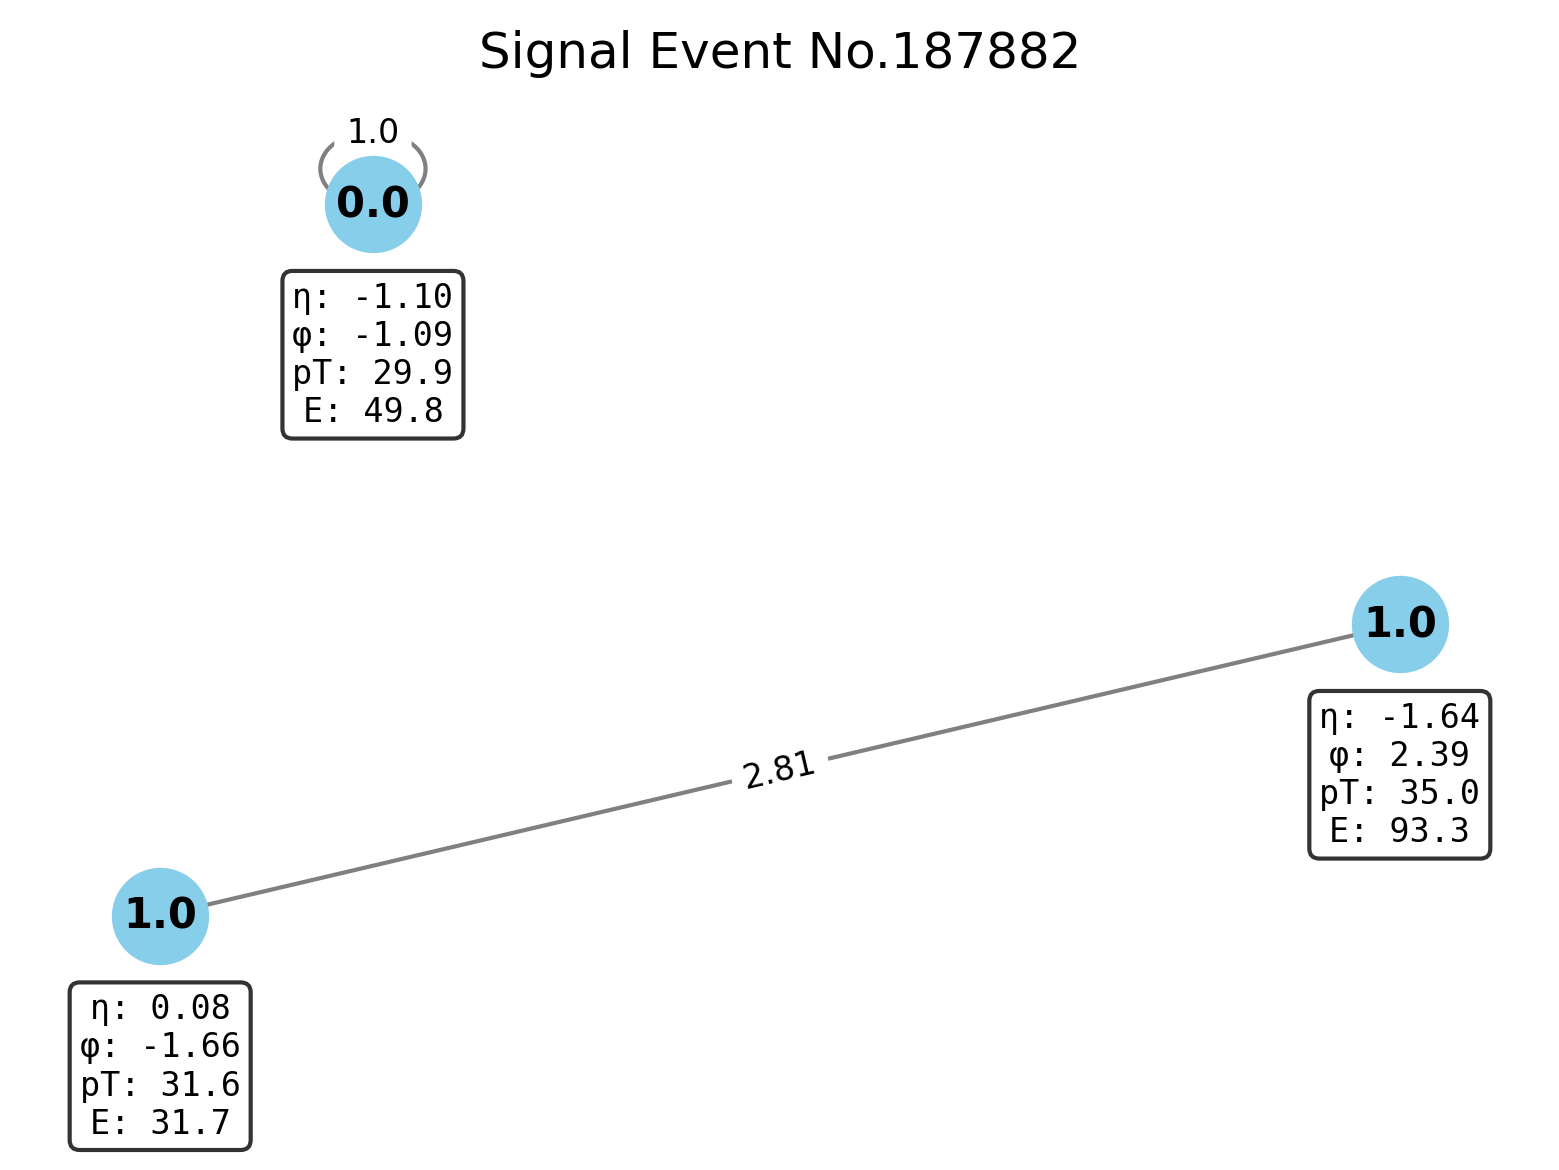

In [22]:
# from helper_function_module import visualize_graph
visualize_graph(dataset[123], save_fig = False, save_fig_path = 'isolatedPhoton.png')

## Model 4 Best

In [25]:
class GCNClassifier(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_dim, num_graph_features,*, num_hidden_graph_features=0):
        """
        GCN architecture for graph classification.

        Parameters:
        -----------
        num_node_features : int
            Number of features for each node.
        hidden_dim : int
            Dimension of the hidden layer embeddings.
        num_graph_features : int
            Number of additional graph-level features.
        """
        super(GCNClassifier, self).__init__()

        if num_hidden_graph_features != 0:
            self.classify = torch.nn.Sequential(
                torch.nn.Linear(hidden_dim + num_hidden_graph_features, 128),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(128, 1), 
            )
            
            self.graph_features_nn = torch.nn.Sequential(
            torch.nn.Linear(num_graph_features, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(64, num_hidden_graph_features)
            )

        else:
            self.classify = torch.nn.Sequential(
                torch.nn.Linear(hidden_dim + num_graph_features, 128),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(128, 1)
            )

        ############### Model 4 - Best
        # self.lin0 = torch.nn.Linear(num_node_features, hidden_dim)
        self.edge_nn = torch.nn.Sequential(
            torch.nn.Linear(num_edge_features, 64),
             torch.nn.ReLU(),
             torch.nn.Linear(64, hidden_dim * hidden_dim)
        )
        
        # self.conv1 = NNConv(hidden_dim, hidden_dim, nn = self.edge_nn, aggr='max')
        self.conv2 = GCNConv(num_node_features, hidden_dim)
        # self.conv3 = CGConv((hidden_dim, hidden_dim), aggr = 'max')
        # self.conv4 = GMMConv(hidden_dim, hidden_dim, dim=1, kernel_size=5)
        # self.conv5 = GatedGraphConv(hidden_dim, 5, aggr = 'max')
        # self.conv6 = ResGatedGraphConv(hidden_dim, hidden_dim, edge_dim = 1)
        # self.conv7 = GATConv(hidden_dim, hidden_dim)
        self.global_mean_pool_hook = global_mean_pool
        self.global_max_pool_hook = global_max_pool
        

    def forward(self, data):
        """
        Forward pass of the GCN model.

        Parameters:
        -----------
        data : Data
            PyTorch Geometric Data object containing graph and its features.

        Returns:
        --------
        out : torch.Tensor
            Predicted probabilities for the graph labels.
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # GCN layers
        # x = F.relu(self.lin0(x))
        # x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        # x = F.relu(self.conv3(x, edge_index, edge_attr))
        # x = F.relu(self.conv4(x, edge_index, edge_attr))
        # x = F.relu(self.conv5(x, edge_index, edge_attr))
        # x = F.relu(self.conv6(x, edge_index, edge_attr))
        # x = F.relu(self.conv7(x, edge_index, edge_attr))
        # x = self.global_mean_pool_hook(x, data.batch)  # Shape: (batch_size, hidden_dim)
        x = self.global_max_pool_hook(x, data.batch)

        graph_features = torch.cat([data.inv_mass.view(-1, 1)], dim=1)
        
        x = torch.cat([x, graph_features], dim=1)
        self.graph_embedding = x
        # Fully connected layers
        x = self.classify(x)

        return torch.sigmoid(x)


In [26]:
from helper_function_module import train, test
model = GCNClassifier(num_node_features=4,
                      num_edge_features = 1,
                      hidden_dim=10,
                      num_graph_features=1,
                      num_hidden_graph_features = 0).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad = False)
criterion = torch.nn.BCELoss().to(device)

EPOCHS = 250
training_loss = []
test_accuracy = []
torch.cuda.empty_cache()

with tqdm(total=EPOCHS, desc="Training Progress", leave=True) as pbar:
    for epoch in range(EPOCHS):
        loss = train(model, train_loader, device, optimizer, criterion)
        acc = test(model, test_loader, device, optimizer, criterion)
        training_loss.append(loss)
        test_accuracy.append(acc)

        pbar.set_postfix({'Loss': f'{loss:.4f}', 'Accuracy': f'{acc:.4f}'})
        pbar.update(1)

Training Progress: 100%|██████████| 250/250 [00:49<00:00,  5.05it/s, Loss=0.5271, Accuracy=0.7913]


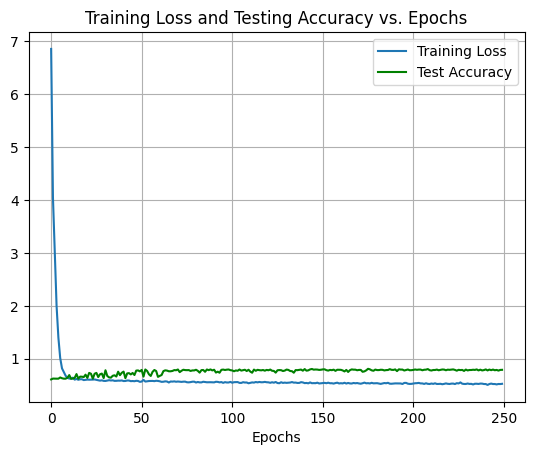

In [27]:
plt.plot([epoch for epoch in range(EPOCHS)], training_loss, label = 'Training Loss')
plt.plot([epoch for epoch in range(EPOCHS)], test_accuracy, color = 'g', label = 'Test Accuracy')
plt.legend()
plt.title('Training Loss and Testing Accuracy vs. Epochs')
plt.xlabel('Epochs')
# plt.ylim([0,2])
plt.grid(which = 'both')
plt.savefig('isolatedPhoton_GCNConvTrainingLoss_TestAccuracy.png', dpi=300)
plt.show()

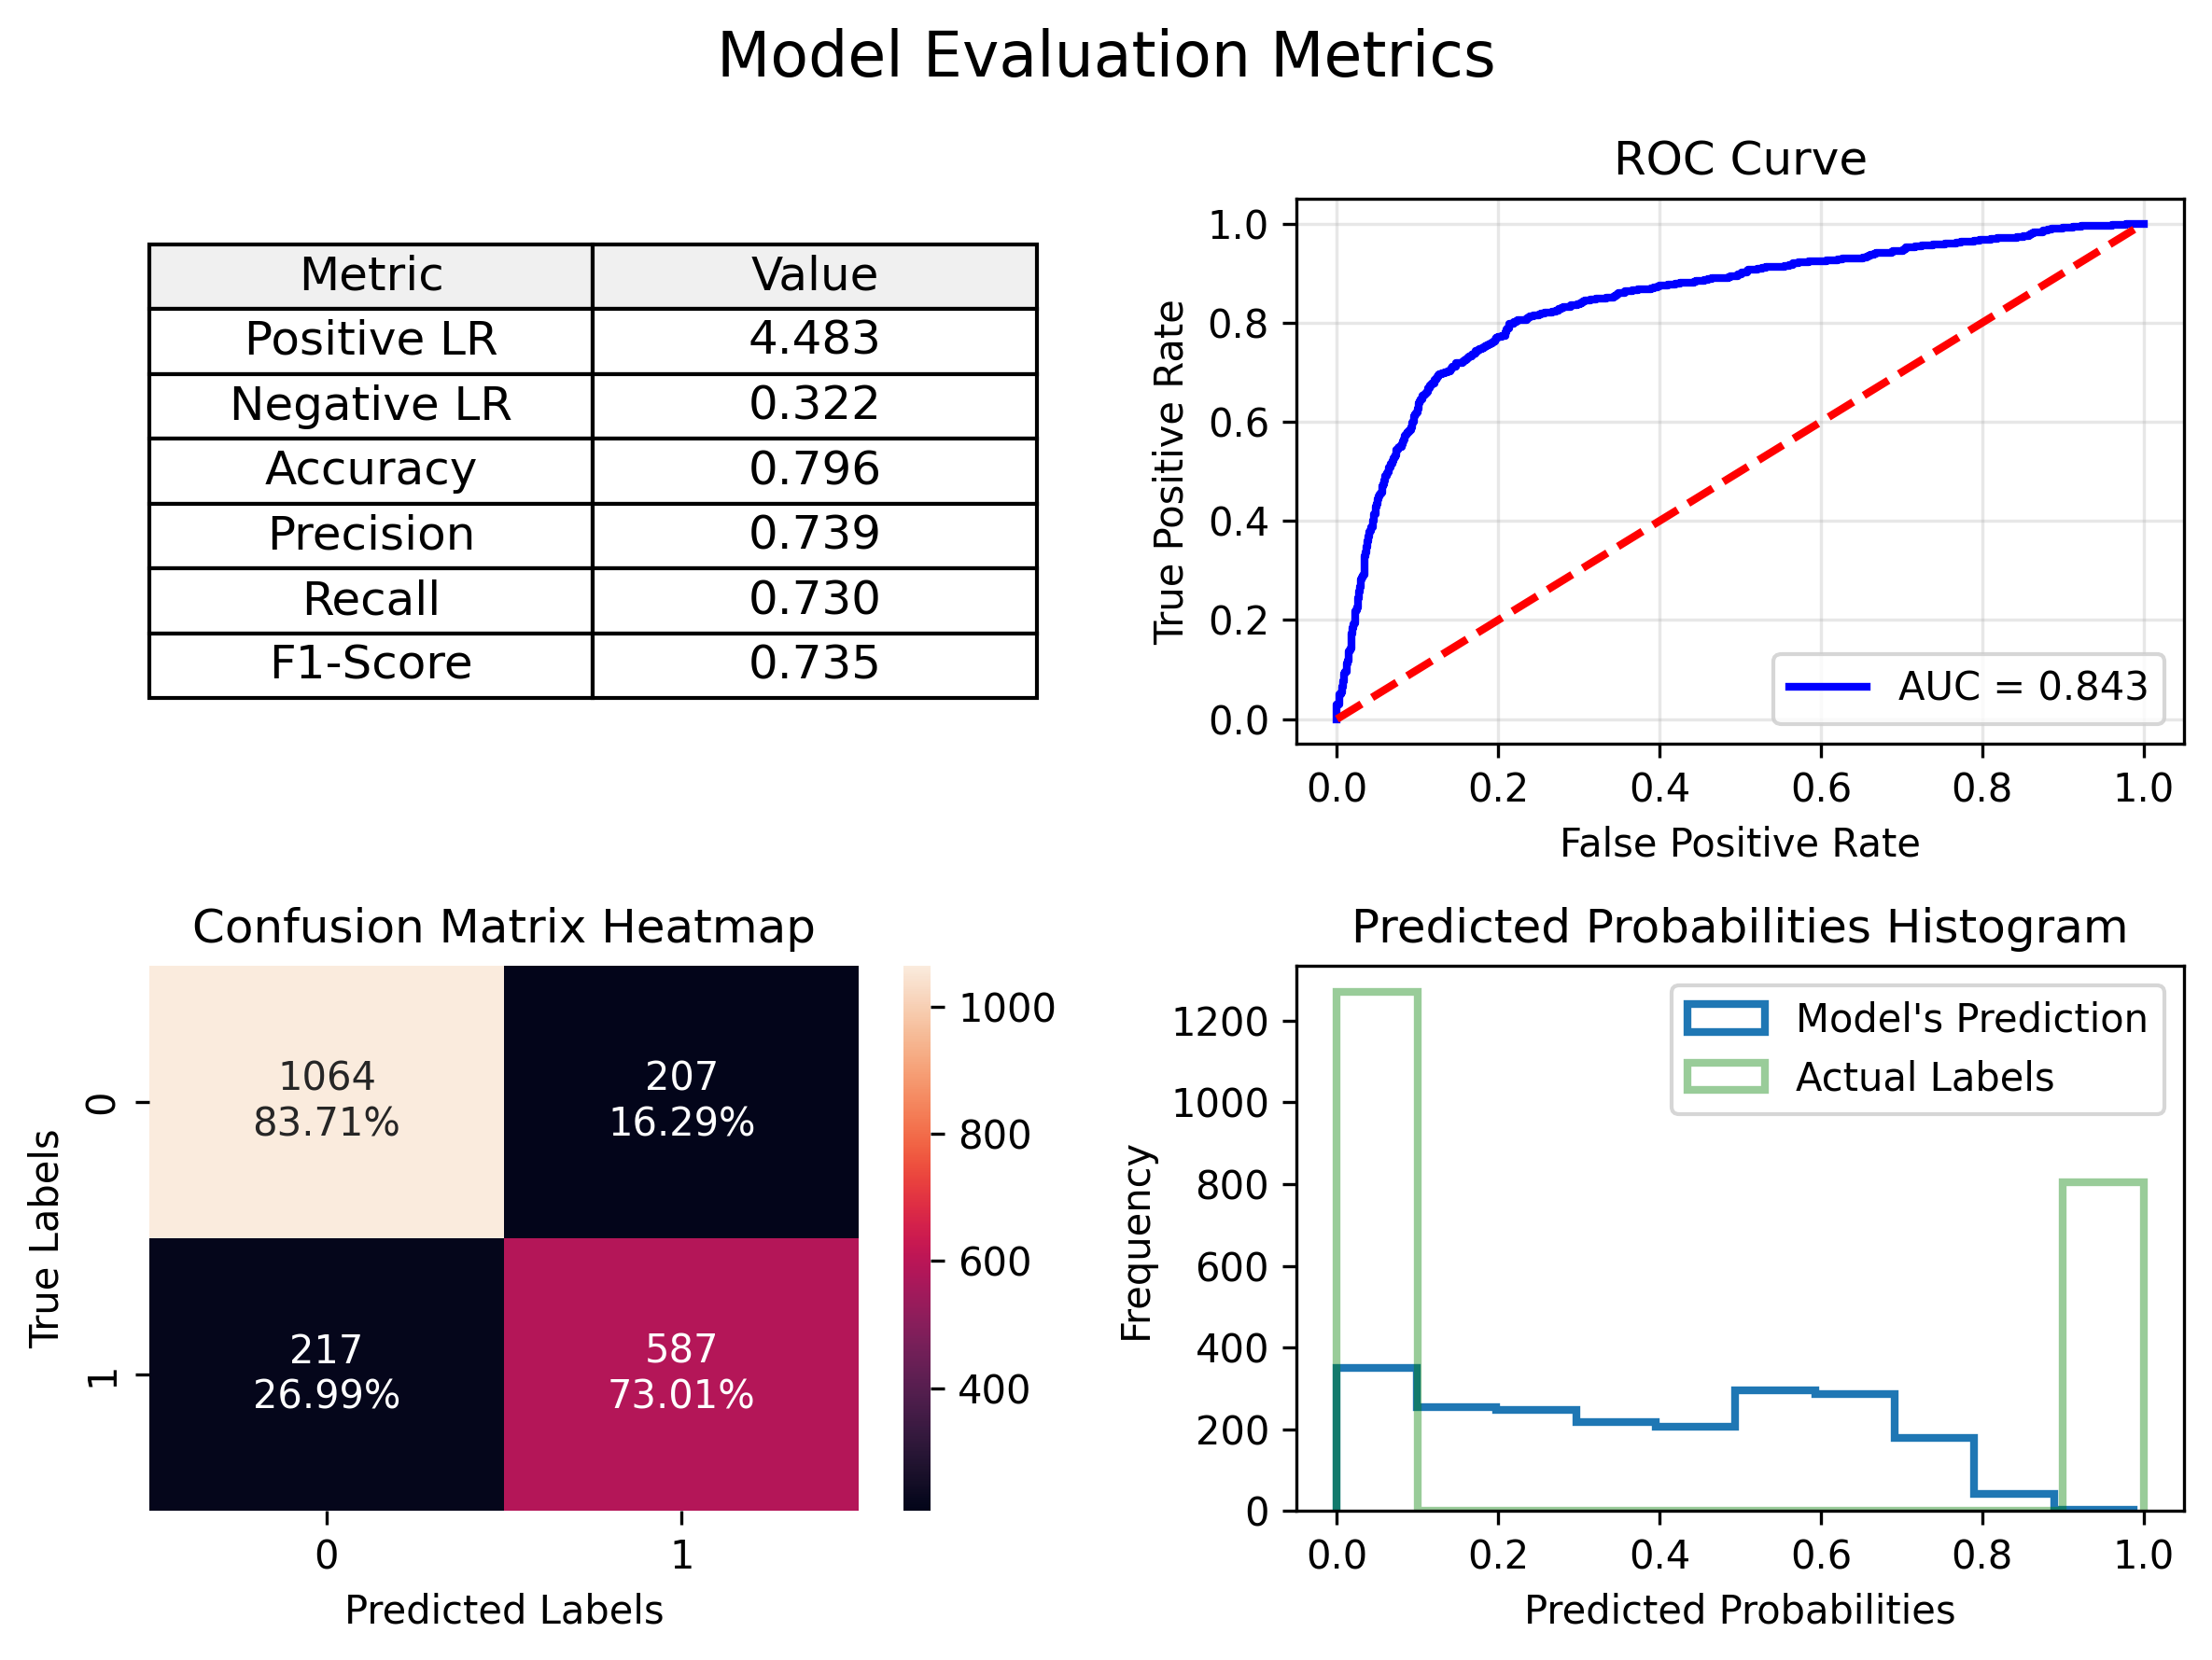

In [28]:
from helper_function_module import eval_model, get_labels_from_model
y_true, y_pred_prob, y_pred_labels = get_labels_from_model(model, dataset)
eval_model(y_true, y_pred_prob, y_pred_labels)

In [45]:
from collections import Counter
Counter(y_true)

Counter({0.0: 1271, 1.0: 804})

# Testing the Model Performance on Test Data

Figure saved to isolatedPhoton_GCNConv_MetricPlot.png successfully :)


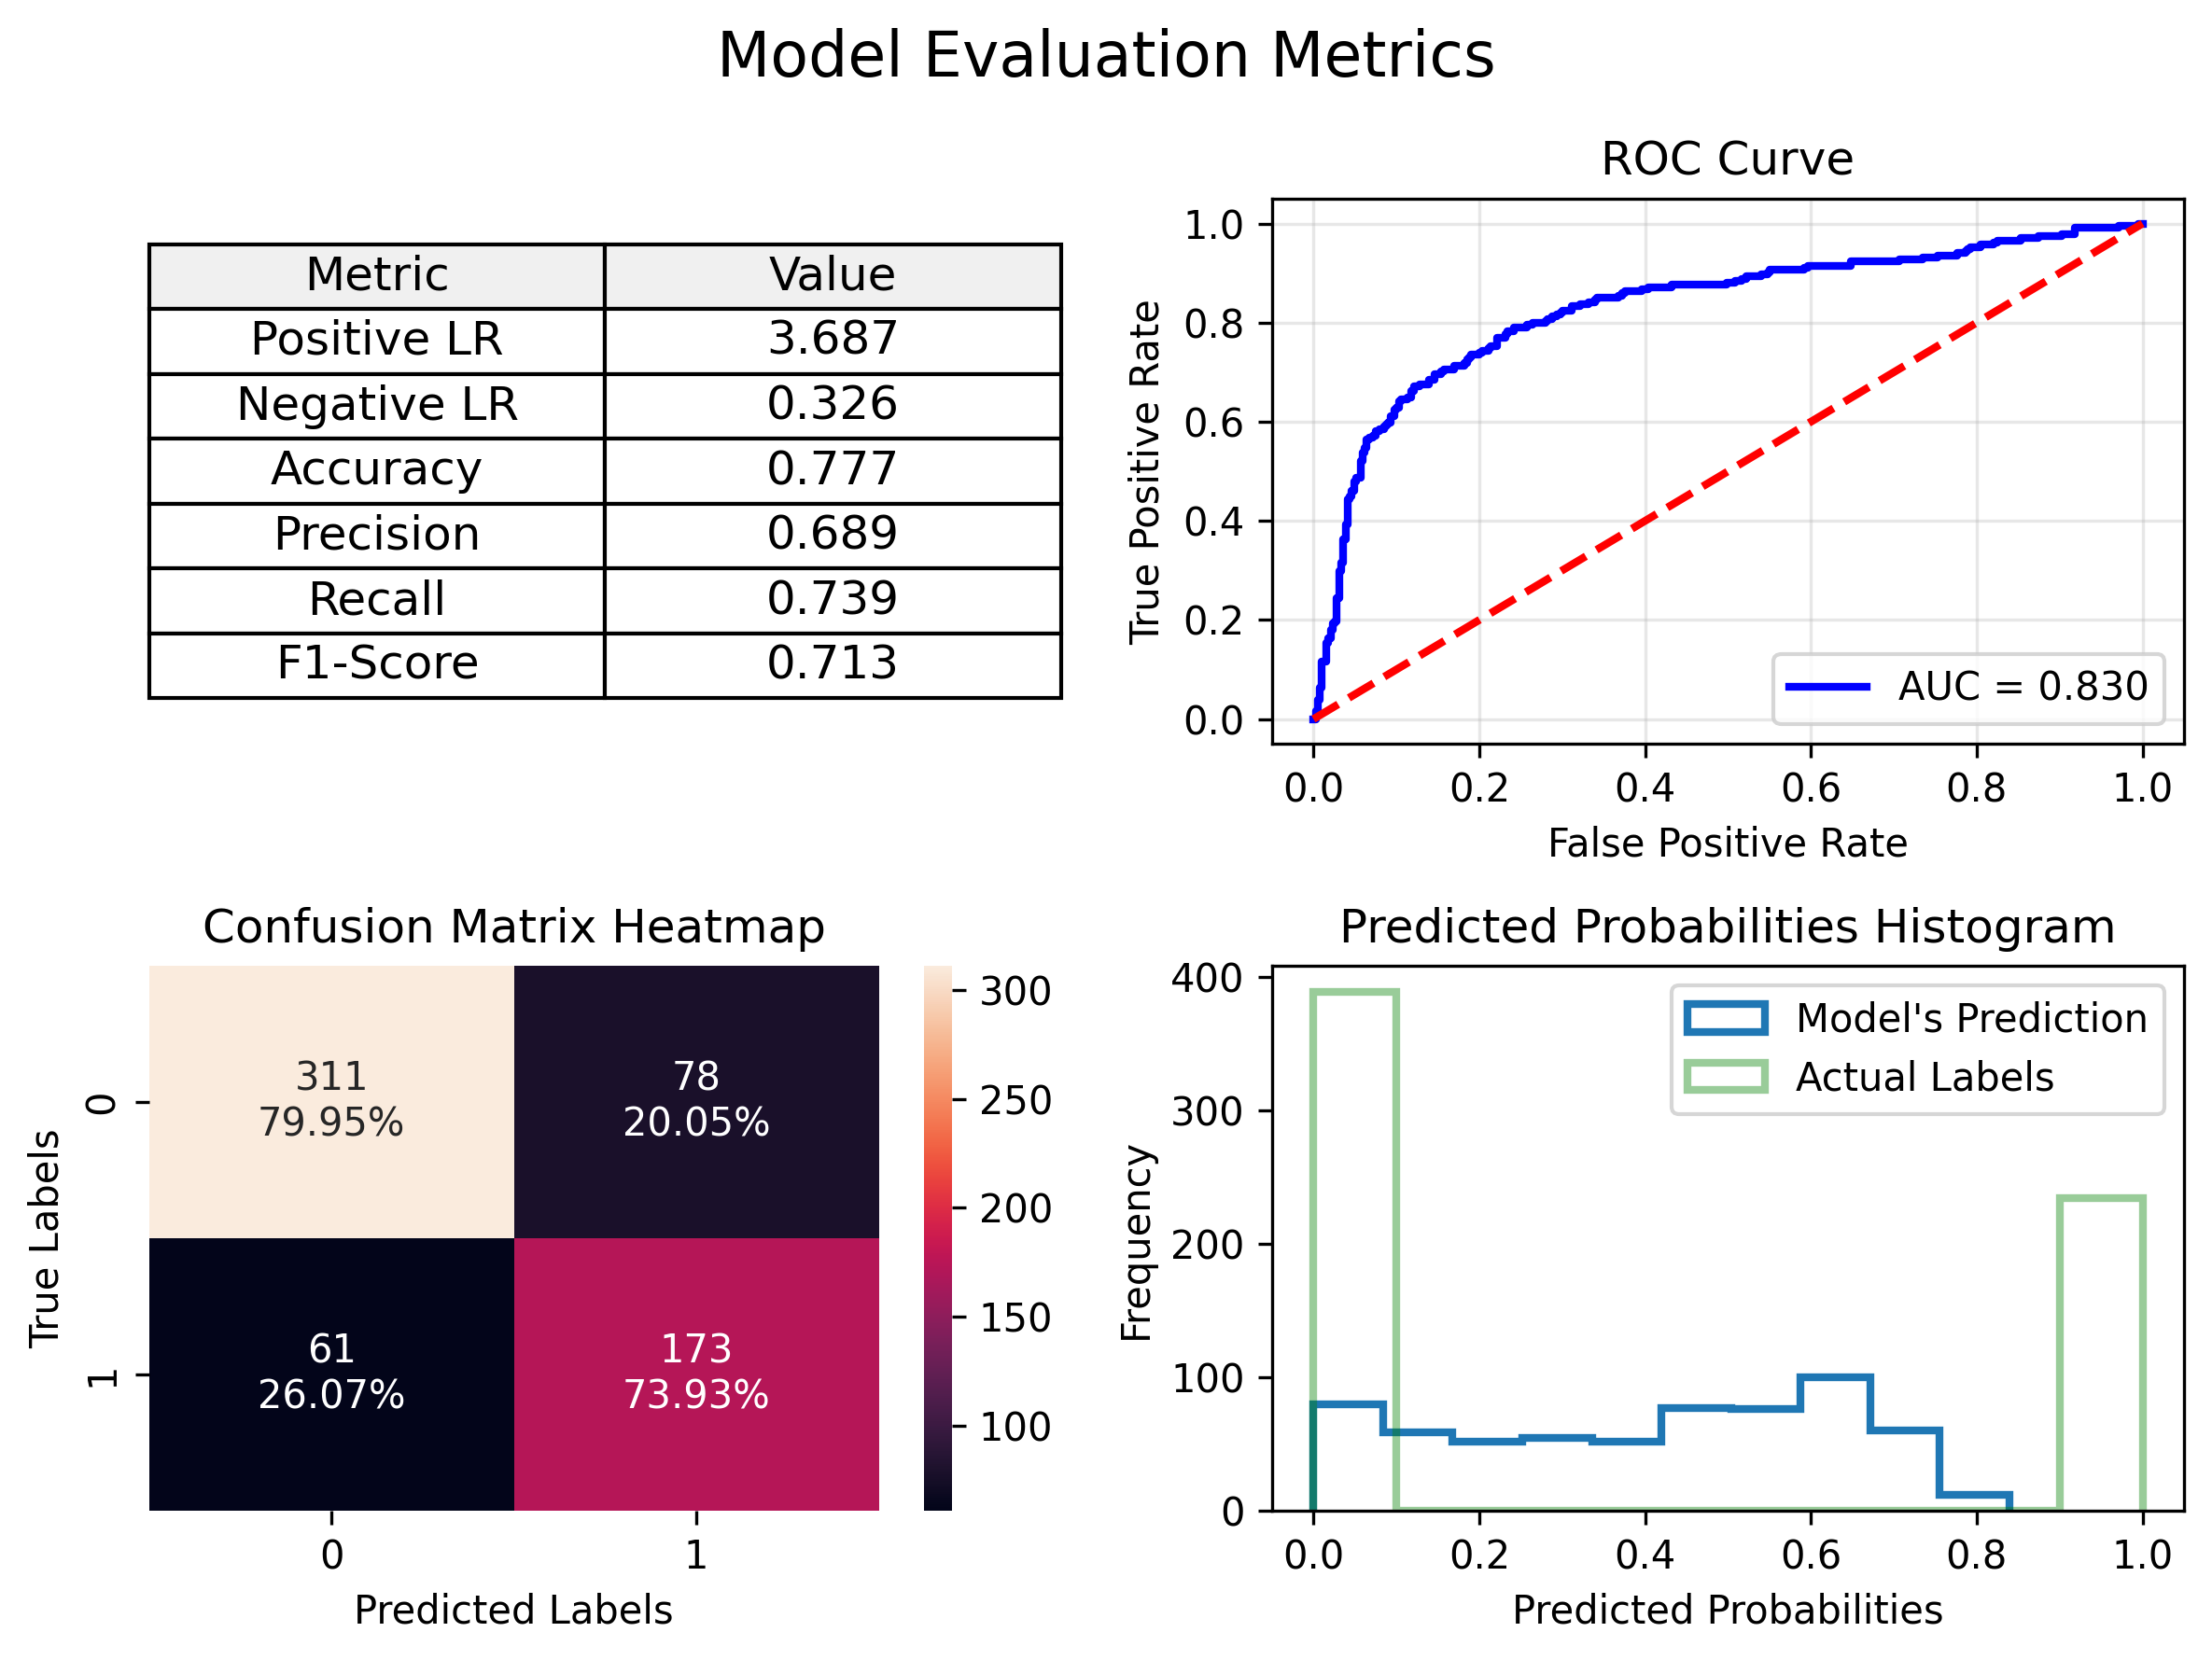

In [46]:
y_test_true, y_test_pred_prob, y_test_pred_labels = get_labels_from_model(model, test_dataset)
eval_model(y_test_true, y_test_pred_prob, y_test_pred_labels, save_fig = True, save_fig_path = 'isolatedPhoton_GCNConv_MetricPlot.png')

In [47]:
# np.save('GatedGConv_977auc_model_pred', np.vstack((y_true, y_pred_prob)))
# torch.save(model, 'GatedGConv_977auc_model.pth')

# Extracting Graph Embedding from the Model

In [48]:
from helper_function_module import get_graph_embeddings
embedding_df = get_graph_embeddings(model, dataset)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [49]:
# np.save('GatedGConv_977auc_model_embeddings', embedding_df)

## Classifying the Graph Embeddings Using a Random Forest Model from these graph embeddings

In [58]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

In [51]:
X, y = embedding_df.iloc[:,:-2].values, embedding_df.iloc[:,-2].values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [52]:
param_grid_forest = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}
grid_search_forest = GridSearchCV(RandomForestClassifier(random_state=seed),
                          param_grid=param_grid_forest,
                          cv=5,
                          n_jobs=-1)
grid_search_forest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=4573),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

Best Model Test Accuracy: 0.75
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
ROC AUC: 0.80


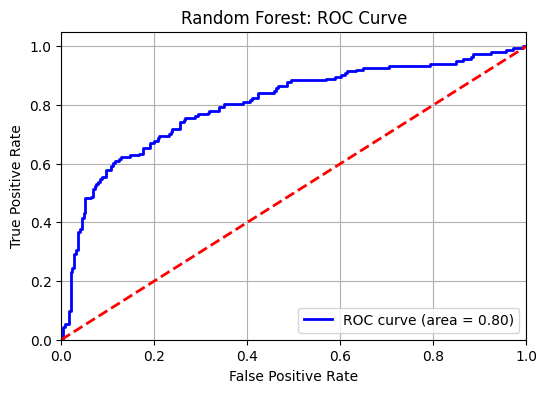

In [60]:
best_model = grid_search_forest.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Model Test Accuracy: {accuracy:.2f}')
print(f'Best Hyperparameters: {grid_search_forest.best_params_}')

# Calculate ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.2f}')

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest: ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## ANN Based Classifier

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [55]:
model_ANN = Sequential([
    Input(shape = (11,)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model_ANN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Train the model
history = model_ANN.fit(X_train, y_train, epochs=40, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.5475 - Precision: 0.4310 - Recall: 0.3734 - accuracy: 0.5656 - loss: 3.8646 - val_AUC: 0.6619 - val_Precision: 0.2667 - val_Recall: 0.0296 - val_accuracy: 0.5723 - val_loss: 0.6790
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.5225 - Precision: 0.3965 - Recall: 0.3567 - accuracy: 0.5354 - loss: 1.4165 - val_AUC: 0.6447 - val_Precision: 0.6222 - val_Recall: 0.2074 - val_accuracy: 0.6265 - val_loss: 0.6613
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.5441 - Precision: 0.4010 - Recall: 0.3972 - accuracy: 0.5333 - loss: 0.8304 - val_AUC: 0.5000 - val_Precision: 0.4066 - val_Recall: 1.0000 - val_accuracy: 0.4066 - val_loss: 0.6947
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.4915 - Precision: 0.3675 - Recall: 0.5391 - accuracy: 0.4730 - loss: 0.7482 - val_AUC: 0.5000 - val_Precision: 0.4066 - val_Recall: 1.0000 - val_accuracy: 0.4066 - val_loss: 0.6938
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0

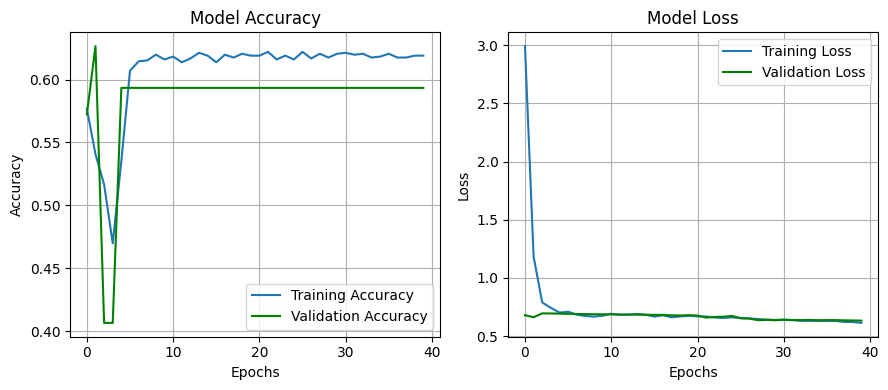

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7283 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.6193 - loss: 0.6192 
Test Loss: 0.6217, Test Accuracy: 0.6048, Precision: 0.0000, Recall: 0.0000, AUC: 0.7448
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Example probabilities: [[0.31389004]
 [0.40829352]
 [0.27622804]
 [0.431043  ]
 [0.28324208]]
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, ROC AUC: 0.7448


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


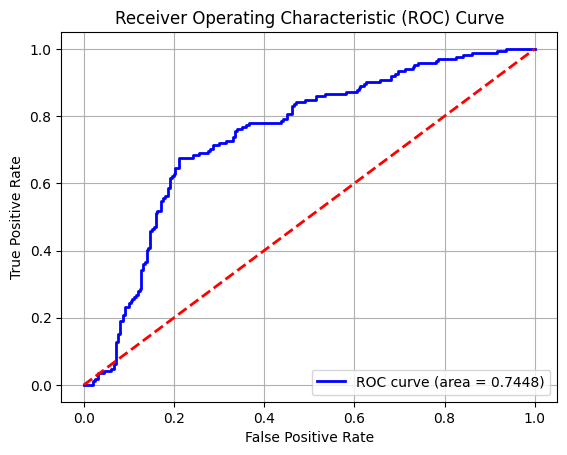

In [62]:
# Plotting training history
plt.figure(figsize=(9, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color = 'green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', color = 'green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
evaluation_results = model_ANN.evaluate(X_test, y_test)
loss, accuracy, precision, recall, auc = evaluation_results
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")

# Predict probabilities for the test set
probability_scores = model_ANN.predict(X_test)
print("Example probabilities:", probability_scores[:5])

# Additional evaluation metrics
predictions = (probability_scores > 0.5).astype(int)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, probability_scores)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probability_scores)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [67]:
sig_dataset_E = []
bg_dataset_E = []

for data in signal_pyg_graphs:
    num_nodes = data.x.size()[0]
    if (num_nodes == 3) & (data.count_isophoton.item() == 1) & (data.count_btag_jets.item() == 2):
        sig_dataset_E.append(data.x.numpy()[0,-1])

for data in background_pyg_graphs:
    num_nodes = data.x.size()[0]
    if (num_nodes == 3) & (data.count_isophoton.item() == 1) & (data.count_btag_jets.item() == 2):
        bg_dataset_E.append(data.x.numpy()[0,-1])

sig_dataset_E, bg_dataset_E = np.array(sig_dataset_E), np.array(bg_dataset_E)

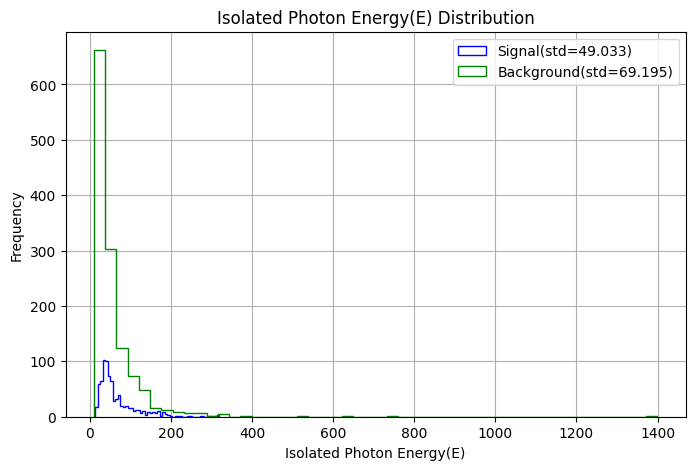

In [68]:
plt.figure(figsize=(8,5))
plt.hist(sig_dataset_E, bins = 50, color = 'blue', histtype = 'step', label=f"Signal(std={sig_dataset_E.std():.3f})")
plt.hist(bg_dataset_E, bins = 50, color = 'green', histtype = 'step', label=f"Background(std={bg_dataset_E.std():.3f})")
plt.xlabel('Isolated Photon Energy(E)')
plt.ylabel('Frequency')
plt.title('Isolated Photon Energy(E) Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
dataset[500].x.numpy()[0,-1]

18.9919